# 1) Dataset

As bases de dados utilizadas são provenientes do **Banco Central do Brasil (BCB)**, mais especificamente do **Sistema Gerenciador de Séries Temporais (SGS)** e da tabela de **Metas da Taxa Selic**.

### Fontes de dados:
- **Sistema Gerenciador de Séries Temporais (SGS/BCB):**  
  [Acessar SGS/BCB](https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries)

- **Metas de taxa para a Selic:**  
  [Acessar Metas da Selic](https://www.bcb.gov.br/estatisticas/detalhamentoGrafico/graficosestatisticas/metaselic)

- **Tabela de estatísticas monetárias e de crédito**  
  (contém as séries administradas pelo SGS em formato `.xlsx`):  
  [Acessar estatísticas monetárias e de crédito](https://www.bcb.gov.br/estatisticas/estatisticasmonetariascredito)


## Coletando as séries do Sistema Gerenciador de Séries Temporais / BCB

In [2]:
import time
import math
import requests  # cliente HTTP
import pandas as pd
from datetime import datetime
from pathlib import Path

URL_BASE = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo}/dados"

def baixar_sgs(codigo: int, data_inicial: str, data_final: str, tentativas_max: int = 5) -> pd.DataFrame:
    """
    Baixa UMA série do SGS em JSON e devolve DataFrame com colunas: ['dt', f'sgs_{codigo}'].
    data_inicial/data_final no formato 'dd/mm/aaaa'. Backoff simples em caso de erro HTTP.
    """
    parametros = {"formato": "json", "dataInicial": data_inicial, "dataFinal": data_final}
    for tentativa in range(tentativas_max):
        try:
            resp = requests.get(URL_BASE.format(codigo=codigo), params=parametros, timeout=30)
            resp.raise_for_status()
            dados = resp.json()
            df = pd.DataFrame(dados)
            if df.empty:
                return pd.DataFrame(columns=["dt", f"sgs_{codigo}"])
            # Converte data (pode vir dd/mm/aaaa ou mm/aaaa)
            def parsear_data(s):
                for fmt in ("%d/%m/%Y", "%m/%Y"):
                    try:
                        return datetime.strptime(s, fmt)
                    except ValueError:
                        pass
                return pd.NaT
            df["dt"] = df["data"].apply(parsear_data)
            df[f"sgs_{codigo}"] = pd.to_numeric(df["valor"].str.replace(",", "."), errors="coerce")
            saida = df[["dt", f"sgs_{codigo}"]].dropna(subset=["dt"]).copy()
            # normaliza para frequência mensal (MS)
            saida = (
                saida.set_index("dt")
                     .sort_index()
                     .asfreq("MS")  # Month Start
                     .ffill()       # preenche mês faltante com último valor
            )
            saida.reset_index(inplace=True)
            return saida
        except requests.RequestException as e:
            espera = 2 ** tentativa
            time.sleep(espera)
            if tentativa == tentativas_max - 1:
                raise e

def baixar_varias(codigos: list[int], data_inicial: str, data_final: str) -> pd.DataFrame:
    """
    Faz merge (outer) de várias séries por 'dt'. Retorna DataFrame com dt + colunas sgs_XXXX.
    """
    df_todas = None
    for codigo in codigos:
        df_serie = baixar_sgs(codigo, data_inicial, data_final)
        df_todas = df_serie if df_todas is None else df_todas.merge(df_serie, on="dt", how="outer")
    # index mensal e ordenação
    return df_todas.set_index("dt").sort_index().asfreq("MS")

# conjuntos de séries que serão utilizadas na análise
CODIGOS_LIVRES = [20635, 20662, 20634, 20718, 20740, 20717, 20787, 20809, 20786, 21085, 21086, 21112]
CODIGOS_ICC_LIVRES = [25355, 25356, 25354]  # opcional

CODIGOS_DIRECIONADOS = [20686, 20698, 20685, 20757, 20768, 20756, 20826, 20837, 20825, 21132, 21133, 21145]
CODIGOS_ICC_DIRECIONADOS = [25358, 25359, 25357]  # opcional

INCLUIR_ICC = True
CODIGOS_LIVRES_FINAIS = CODIGOS_LIVRES + (CODIGOS_ICC_LIVRES if INCLUIR_ICC else [])
CODIGOS_DIRECIONADOS_FINAIS = CODIGOS_DIRECIONADOS + (CODIGOS_ICC_DIRECIONADOS if INCLUIR_ICC else [])

# datas-alvo
DATA_INICIAL = "01/01/2022"
DATA_FINAL = datetime.today().strftime("%d/%m/%Y")

# baixa e organiza 
df_livres = baixar_varias(CODIGOS_LIVRES_FINAIS, DATA_INICIAL, DATA_FINAL)
df_direcionados = baixar_varias(CODIGOS_DIRECIONADOS_FINAIS, DATA_INICIAL, DATA_FINAL)


conjunto_dados = df_livres.join(df_direcionados, how="outer")

conjunto_dados


,sgs_20635,sgs_20662,sgs_20634,sgs_20718,sgs_20740,sgs_20717,sgs_20787,sgs_20809,sgs_20786,sgs_21085,...,sgs_20756,sgs_20826,sgs_20837,sgs_20825,sgs_21132,sgs_21133,sgs_21145,sgs_25358,sgs_25359,sgs_25357
dt,,,,,,,,,,,,,,,,,,,,,
2022-01-01,178243,200482,378725,21.30,45.51,34.84,10.81,34.58,24.10,3.26,...,9.65,2.57,3.66,3.40,1.27,0.99,1.42,8.57,7.92,8.15
2022-02-01,181252,187146,368398,21.43,47.28,35.95,10.65,36.04,24.91,3.26,...,9.03,2.98,3.88,3.66,1.41,1.08,1.59,8.60,7.95,8.18
2022-03-01,242336,230064,472399,21.39,48.70,36.73,10.14,36.86,25.15,3.41,...,10.05,2.73,3.91,3.62,1.38,1.06,1.55,8.68,7.99,8.23
2022-04-01,200814,223322,424136,22.31,49.06,37.35,10.19,37.17,25.36,3.52,...,11.15,3.24,4.02,3.83,1.34,1.10,1.48,8.76,8.07,8.32
2022-05-01,218693,239059,457752,21.84,49.56,37.46,10.10,37.16,25.35,3.65,...,10.79,1.80,3.93,3.40,1.30,1.08,1.42,8.83,8.19,8.41
2022-06-01,221138,227180,448319,22.56,50.65,38.41,10.45,37.89,25.93,3.62,...,10.57,2.76,3.93,3.64,1.18,1.01,1.27,8.93,8.30,8.52
2022-07-01,198956,227425,426381,23.33,52.44,39.78,10.83,39.27,26.90,3.80,...,11.97,6.86,3.65,4.43,1.21,1.04,1.30,9.10,8.41,8.65
2022-08-01,217395,243934,461329,22.67,53.10,39.98,10.59,40.62,27.67,3.92,...,10.14,3.01,3.96,3.73,1.17,0.96,1.29,9.14,8.51,8.73
2022-09-01,224562,236630,461192,22.80,52.77,39.85,10.94,40.49,27.75,3.98,...,10.44,3.82,4.30,4.19,1.16,0.95,1.27,9.17,8.59,8.79


# Mapa de Séries do Bacen (SGS)

As séries foram organizadas em dois grandes grupos: **Recursos Livres (RL)** e **Recursos Direcionados (RD)**.  
Cada grupo contém informações sobre **concessões de crédito**, **taxas de juros médias**, **spreads bancários** e o **Índice de Custo de Crédito (ICC)**, separados por **Pessoa Jurídica (PJ)**, **Pessoa Física (PF)** e **Total (TOT)**.

---

## 📌 Recursos Livres (RL)

Recursos livres são operações de crédito em que as instituições financeiras têm maior liberdade para definir taxas, prazos e condições, sem vinculação legal obrigatória.

### Concessões de Crédito
- **sgs_20635 → concessoes_RL_PJ**  
  Valor de novas concessões de crédito em recursos livres para **Pessoa Jurídica**.  
- **sgs_20662 → concessoes_RL_PF**  
  Valor de novas concessões de crédito em recursos livres para **Pessoa Física**.  
- **sgs_20634 → concessoes_RL_TOT**  
  Total de concessões de crédito em recursos livres (**PJ + PF**).  

### Taxa de Juros Média
- **sgs_20718 → taxa_RL_PJ**  
  Taxa de juros média das operações de crédito com recursos livres para **PJ**.  
- **sgs_20740 → taxa_RL_PF**  
  Taxa de juros média das operações de crédito com recursos livres para **PF**.  
- **sgs_20717 → taxa_RL_TOT**  
  Taxa de juros média consolidada das operações de crédito com recursos livres.  

### Spread Bancário  
(O spread representa a diferença entre a taxa de juros cobrada do tomador e o custo de captação do banco.)  
- **sgs_20787 → spread_RL_PJ**  
  Spread das operações de crédito com recursos livres para **PJ**.  
- **sgs_20809 → spread_RL_PF**  
  Spread das operações de crédito com recursos livres para **PF**.  
- **sgs_20786 → spread_RL_TOT**  
  Spread médio consolidado em recursos livres.

### Inadimplência da Carteira de Crédito  
(A **inadimplência** representa o percentual de operações de crédito com **atraso superior a 90 dias** em relação ao saldo total da carteira.  
É um importante indicador de **risco de crédito**, refletindo a capacidade dos tomadores de honrarem seus compromissos financeiros.)  
- **sgs_21086 → inad90_RL_PJ**  
  Percentual de operações inadimplentes (>90 dias) para **PJ** em recursos livres.  
- **sgs_21112 → inad90_RL_PF**  
  Percentual de operações inadimplentes (>90 dias) para **PF** em recursos livres.  
- **sgs_21085 → inad90_RL_TOT**  
  Percentual total de operações inadimplentes (>90 dias) em recursos livres.  

### Índice de Custo de Crédito (ICC)  
(O ICC mede o **custo médio do crédito no Brasil**, ponderando diferentes modalidades de crédito. Funciona como um indicador sintético do preço do crédito, semelhante a como o IPCA resume preços.)  
- **sgs_25355 → icc_RL_PJ**  
  Índice de custo do crédito em recursos livres para **PJ**.  
- **sgs_25356 → icc_RL_PF**  
  Índice de custo do crédito em recursos livres para **PF**.  
- **sgs_25354 → icc_RL_TOT**  
  Índice consolidado de custo do crédito em recursos livres.  

---

## 📌 Recursos Direcionados (RD)

Recursos direcionados são operações de crédito com **destinação obrigatória definida em lei**, geralmente com condições favorecidas (ex.: crédito rural, habitacional, BNDES).

### Concessões de Crédito
- **sgs_20686 → concessoes_RD_PJ**  
  Valor de novas concessões de crédito direcionado para **PJ**.  
- **sgs_20698 → concessoes_RD_PF**  
  Valor de novas concessões de crédito direcionado para **PF**.  
- **sgs_20685 → concessoes_RD_TOT**  
  Total de concessões de crédito direcionado (**PJ + PF**).  

### Taxa de Juros Média
- **sgs_20757 → taxa_RD_PJ**  
  Taxa de juros média das operações de crédito direcionado para **PJ**.  
- **sgs_20768 → taxa_RD_PF**  
  Taxa de juros média das operações de crédito direcionado para **PF**.  
- **sgs_20756 → taxa_RD_TOT**  
  Taxa de juros média consolidada em crédito direcionado.  

### Spread Bancário
- **sgs_20826 → spread_RD_PJ**  
  Spread das operações de crédito direcionado para **PJ**.  
- **sgs_20837 → spread_RD_PF**  
  Spread das operações de crédito direcionado para **PF**.  
- **sgs_20825 → spread_RD_TOT**  
  Spread médio consolidado em crédito direcionado.

### Inadimplência da Carteira de Crédito  
(A **inadimplência** indica o percentual de operações com **atraso superior a 90 dias** no pagamento.  
Reflete o **risco de crédito** e a saúde da carteira de operações direcionadas.)  
- **sgs_21133 → inad90_RD_PJ**  
  Percentual de operações inadimplentes (>90 dias) para **PJ** em recursos direcionados.  
- **sgs_21145 → inad90_RD_PF**  
  Percentual de operações inadimplentes (>90 dias) para **PF** em recursos direcionados.  
- **sgs_21132 → inad90_RD_TOT**  
  Percentual total de operações inadimplentes (>90 dias) em recursos direcionados.  

### Índice de Custo de Crédito (ICC)
- **sgs_25358 → icc_RD_PJ**  
  Índice de custo do crédito direcionado para **PJ**.  
- **sgs_25359 → icc_RD_PF**  
  Índice de custo do crédito direcionado para **PF**.  
- **sgs_25357 → icc_RD_TOT**  
  Índice consolidado de custo do crédito em recursos direcionados.  

---
### Com esse mapa de séries nós iremos alterar as linha, deixando-as identificáveis

In [3]:
mapa_series = {
    # --------- RECURSOS LIVRES (RL) ---------
    "sgs_20635": "concessoes_RL_PJ_20635",
    "sgs_20662": "concessoes_RL_PF_20662",
    "sgs_20634": "concessoes_RL_TOT_20634",

    "sgs_20718": "taxa_RL_PJ_20718",
    "sgs_20740": "taxa_RL_PF_20740",
    "sgs_20717": "taxa_RL_TOT_20717",

    "sgs_20787": "spread_RL_PJ_20787",
    "sgs_20809": "spread_RL_PF_20809",
    "sgs_20786": "spread_RL_TOT_20786",

    "sgs_21086": "inad90_RL_PJ_21086",
    "sgs_21112": "inad90_RL_PF_21112",
    "sgs_21085": "inad90_RL_TOT_21085",

    "sgs_25355": "icc_RL_PJ_25355",
    "sgs_25356": "icc_RL_PF_25356",
    "sgs_25354": "icc_RL_TOT_25354",

    # --------- RECURSOS DIRECIONADOS (RD) ---------
    "sgs_20686": "concessoes_RD_PJ_20686",
    "sgs_20698": "concessoes_RD_PF_20698",
    "sgs_20685": "concessoes_RD_TOT_20685",

    "sgs_20757": "taxa_RD_PJ_20757",
    "sgs_20768": "taxa_RD_PF_20768",
    "sgs_20756": "taxa_RD_TOT_20756",

    "sgs_20826": "spread_RD_PJ_20826",
    "sgs_20837": "spread_RD_PF_20837",
    "sgs_20825": "spread_RD_TOT_20825",

    "sgs_21133": "inad90_RD_PJ_21133",
    "sgs_21145": "inad90_RD_PF_21145",
    "sgs_21132": "inad90_RD_TOT_21132",

    "sgs_25358": "icc_RD_PJ_25358",
    "sgs_25359": "icc_RD_PF_25359",
    "sgs_25357": "icc_RD_TOT_25357",
}

# renomeia as colunas usando o dicionário
conjunto_dados = conjunto_dados.rename(columns=mapa_series).copy()

conjunto_dados

,concessoes_RL_PJ_20635,concessoes_RL_PF_20662,concessoes_RL_TOT_20634,taxa_RL_PJ_20718,taxa_RL_PF_20740,taxa_RL_TOT_20717,spread_RL_PJ_20787,spread_RL_PF_20809,spread_RL_TOT_20786,inad90_RL_TOT_21085,...,taxa_RD_TOT_20756,spread_RD_PJ_20826,spread_RD_PF_20837,spread_RD_TOT_20825,inad90_RD_TOT_21132,inad90_RD_PJ_21133,inad90_RD_PF_21145,icc_RD_PJ_25358,icc_RD_PF_25359,icc_RD_TOT_25357
dt,,,,,,,,,,,,,,,,,,,,,
2022-01-01,178243,200482,378725,21.30,45.51,34.84,10.81,34.58,24.10,3.26,...,9.65,2.57,3.66,3.40,1.27,0.99,1.42,8.57,7.92,8.15
2022-02-01,181252,187146,368398,21.43,47.28,35.95,10.65,36.04,24.91,3.26,...,9.03,2.98,3.88,3.66,1.41,1.08,1.59,8.60,7.95,8.18
2022-03-01,242336,230064,472399,21.39,48.70,36.73,10.14,36.86,25.15,3.41,...,10.05,2.73,3.91,3.62,1.38,1.06,1.55,8.68,7.99,8.23
2022-04-01,200814,223322,424136,22.31,49.06,37.35,10.19,37.17,25.36,3.52,...,11.15,3.24,4.02,3.83,1.34,1.10,1.48,8.76,8.07,8.32
2022-05-01,218693,239059,457752,21.84,49.56,37.46,10.10,37.16,25.35,3.65,...,10.79,1.80,3.93,3.40,1.30,1.08,1.42,8.83,8.19,8.41
2022-06-01,221138,227180,448319,22.56,50.65,38.41,10.45,37.89,25.93,3.62,...,10.57,2.76,3.93,3.64,1.18,1.01,1.27,8.93,8.30,8.52
2022-07-01,198956,227425,426381,23.33,52.44,39.78,10.83,39.27,26.90,3.80,...,11.97,6.86,3.65,4.43,1.21,1.04,1.30,9.10,8.41,8.65
2022-08-01,217395,243934,461329,22.67,53.10,39.98,10.59,40.62,27.67,3.92,...,10.14,3.01,3.96,3.73,1.17,0.96,1.29,9.14,8.51,8.73
2022-09-01,224562,236630,461192,22.80,52.77,39.85,10.94,40.49,27.75,3.98,...,10.44,3.82,4.30,4.19,1.16,0.95,1.27,9.17,8.59,8.79


# Taxa Selic

## 1. O que é a Taxa Selic?
A **Taxa Selic** é a **taxa básica de juros da economia brasileira**.  
- Ela representa o **custo do dinheiro** nas operações de curtíssimo prazo entre instituições financeiras que utilizam títulos públicos federais como garantia.  
- Serve como **referência para todas as demais taxas de juros do país**, como empréstimos, financiamentos e aplicações financeiras.  
- É definida pelo **Comitê de Política Monetária (Copom)** em reuniões periódicas (a cada 45 dias).  
---

## 2. Por que a Selic é importante para o Estudo?
A Selic é fundamental neste estudo porque representa o instrumento central da política monetária brasileira.  
- **Custo do crédito:** Quando o BCB eleva a Selic, o custo de captação dos bancos aumenta, levando a maiores taxas de juros e spreads bancários.
- **Concessões de crédito:** Juros mais altos reduzem a demanda por crédito, refletindo em menor volume de concessões.
- **Risco e inadimplência:** A elevação da Selic encarece o crédito, podendo impactar a capacidade de pagamento dos tomadores e aumentar o risco de inadimplência.

⚖️ Em resumo:  
- A **Selic é a âncora da política monetária brasileira**.  
- Esse mecanismo é central para garantir **estabilidade econômica, previsibilidade e confiança** nos mercados.

---
### No bloco abaixo nós estamos importando a série 4189: Taxa de Juros - Selic acumulada no mês anualizada

In [5]:
# Selic (SGS 4189) no mesmo padrão das demais séries
df_selic = baixar_varias([4189], DATA_INICIAL, DATA_FINAL)  # índice mensal "MS", com ffill
df_selic = df_selic.rename(columns={"sgs_4189": "selic_4189"})  # nome amigável (opcional)
df_selic

,selic_4189
dt,
2022-01-01,9.15
2022-02-01,10.49
2022-03-01,11.15
2022-04-01,11.65
2022-05-01,12.51
2022-06-01,12.89
2022-07-01,13.15
2022-08-01,13.58
2022-09-01,13.65


## Concatenando a série da Taxa de Juros - Selic com a base inicial

In [6]:
# Alinha df_selic ao índice do conjunto_dados (mesmos meses)
df_selic = df_selic.reindex(conjunto_dados.index)

# Junção das bases
base = conjunto_dados.join(df_selic["selic_4189"], how="left")


base

,concessoes_RL_PJ_20635,concessoes_RL_PF_20662,concessoes_RL_TOT_20634,taxa_RL_PJ_20718,taxa_RL_PF_20740,taxa_RL_TOT_20717,spread_RL_PJ_20787,spread_RL_PF_20809,spread_RL_TOT_20786,inad90_RL_TOT_21085,...,spread_RD_PJ_20826,spread_RD_PF_20837,spread_RD_TOT_20825,inad90_RD_TOT_21132,inad90_RD_PJ_21133,inad90_RD_PF_21145,icc_RD_PJ_25358,icc_RD_PF_25359,icc_RD_TOT_25357,selic_4189
dt,,,,,,,,,,,,,,,,,,,,,
2022-01-01,178243,200482,378725,21.30,45.51,34.84,10.81,34.58,24.10,3.26,...,2.57,3.66,3.40,1.27,0.99,1.42,8.57,7.92,8.15,9.15
2022-02-01,181252,187146,368398,21.43,47.28,35.95,10.65,36.04,24.91,3.26,...,2.98,3.88,3.66,1.41,1.08,1.59,8.60,7.95,8.18,10.49
2022-03-01,242336,230064,472399,21.39,48.70,36.73,10.14,36.86,25.15,3.41,...,2.73,3.91,3.62,1.38,1.06,1.55,8.68,7.99,8.23,11.15
2022-04-01,200814,223322,424136,22.31,49.06,37.35,10.19,37.17,25.36,3.52,...,3.24,4.02,3.83,1.34,1.10,1.48,8.76,8.07,8.32,11.65
2022-05-01,218693,239059,457752,21.84,49.56,37.46,10.10,37.16,25.35,3.65,...,1.80,3.93,3.40,1.30,1.08,1.42,8.83,8.19,8.41,12.51
2022-06-01,221138,227180,448319,22.56,50.65,38.41,10.45,37.89,25.93,3.62,...,2.76,3.93,3.64,1.18,1.01,1.27,8.93,8.30,8.52,12.89
2022-07-01,198956,227425,426381,23.33,52.44,39.78,10.83,39.27,26.90,3.80,...,6.86,3.65,4.43,1.21,1.04,1.30,9.10,8.41,8.65,13.15
2022-08-01,217395,243934,461329,22.67,53.10,39.98,10.59,40.62,27.67,3.92,...,3.01,3.96,3.73,1.17,0.96,1.29,9.14,8.51,8.73,13.58
2022-09-01,224562,236630,461192,22.80,52.77,39.85,10.94,40.49,27.75,3.98,...,3.82,4.30,4.19,1.16,0.95,1.27,9.17,8.59,8.79,13.65


# 2) EDA (Exploratory Data Analysis)

## 1. Definição
**EDA – Análise Exploratória de Dados** é a etapa inicial de um projeto de ciência de dados.  
Ela serve para **entender, limpar e organizar os dados** antes de aplicar modelos estatísticos ou de machine learning.  

👉 Em termos simples: é como "investigar" seus dados para descobrir padrões, erros, outliers (valores muito fora do normal) e relações entre variáveis.

## 2. Objetivos deste EDA
- Visualizar **as séries históricas** (em gráficos, para validar se há sazonalidade).  
- Entender a **correlação entre variáveis** (como elas se relacionam).




In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# escolhe o painel
painel = base.copy()


# garante ordem cronologica das linhas
if not np.issubdtype(painel.index.dtype, np.datetime64):
    painel.index = pd.to_datetime(painel.index, errors="coerce")
painel = painel.sort_index()

,concessoes_RL_PJ_20635,concessoes_RL_PF_20662,concessoes_RL_TOT_20634,taxa_RL_PJ_20718,taxa_RL_PF_20740,taxa_RL_TOT_20717,spread_RL_PJ_20787,spread_RL_PF_20809,spread_RL_TOT_20786,inad90_RL_TOT_21085,...,spread_RD_PJ_20826,spread_RD_PF_20837,spread_RD_TOT_20825,inad90_RD_TOT_21132,inad90_RD_PJ_21133,inad90_RD_PF_21145,icc_RD_PJ_25358,icc_RD_PF_25359,icc_RD_TOT_25357,selic_4189
dt,,,,,,,,,,,,,,,,,,,,,
2022-01-01,178243,200482,378725,21.30,45.51,34.84,10.81,34.58,24.10,3.26,...,2.57,3.66,3.40,1.27,0.99,1.42,8.57,7.92,8.15,9.15
2022-02-01,181252,187146,368398,21.43,47.28,35.95,10.65,36.04,24.91,3.26,...,2.98,3.88,3.66,1.41,1.08,1.59,8.60,7.95,8.18,10.49
2022-03-01,242336,230064,472399,21.39,48.70,36.73,10.14,36.86,25.15,3.41,...,2.73,3.91,3.62,1.38,1.06,1.55,8.68,7.99,8.23,11.15
2022-04-01,200814,223322,424136,22.31,49.06,37.35,10.19,37.17,25.36,3.52,...,3.24,4.02,3.83,1.34,1.10,1.48,8.76,8.07,8.32,11.65
2022-05-01,218693,239059,457752,21.84,49.56,37.46,10.10,37.16,25.35,3.65,...,1.80,3.93,3.40,1.30,1.08,1.42,8.83,8.19,8.41,12.51
2022-06-01,221138,227180,448319,22.56,50.65,38.41,10.45,37.89,25.93,3.62,...,2.76,3.93,3.64,1.18,1.01,1.27,8.93,8.30,8.52,12.89
2022-07-01,198956,227425,426381,23.33,52.44,39.78,10.83,39.27,26.90,3.80,...,6.86,3.65,4.43,1.21,1.04,1.30,9.10,8.41,8.65,13.15
2022-08-01,217395,243934,461329,22.67,53.10,39.98,10.59,40.62,27.67,3.92,...,3.01,3.96,3.73,1.17,0.96,1.29,9.14,8.51,8.73,13.58
2022-09-01,224562,236630,461192,22.80,52.77,39.85,10.94,40.49,27.75,3.98,...,3.82,4.30,4.19,1.16,0.95,1.27,9.17,8.59,8.79,13.65


# 📉 Visualização das Séries Históricas no EDA

## 1. Objetivo da Visualização
Uma das etapas mais importantes da **Análise Exploratória de Dados (EDA)** é **visualizar as séries históricas** em forma de gráficos.  
O objetivo é **compreender o comportamento temporal das variáveis** e identificar padrões que podem influenciar o modelo de previsão.

Ao observar a série no tempo, conseguimos detectar:

- **Tendência:** direção geral dos dados (ex.: crescimento ou queda ao longo dos meses).  
- **Sazonalidade:** variações que se repetem em períodos regulares (mensais, trimestrais ou anuais).  
- **Ciclos econômicos:** movimentos de alta e baixa associados à conjuntura econômica.  
- **Rupturas estruturais:** pontos em que a série muda de comportamento (ex.: crises, novas políticas de crédito).  
- **Outliers:** valores anômalos que destoam do padrão histórico.

---

## 2. Exemplo de Gráfico de Série Histórica

Cada variável (por exemplo, **spread**, **taxa de juros**, **inadimplência**, **concessões** ou **ICC**) pode ser plotada no tempo usando um **gráfico de linha (line plot)**.

### Exemplo prático:
- **Eixo X:** períodos (meses ou anos).  
- **Eixo Y:** valores da série.  
- **Linhas coloridas:** representam diferentes categorias (ex.: PF, PJ, Total).

Esse tipo de visualização ajuda a:
- Confirmar a **estabilidade** ou **volatilidade** das variáveis.  
- Detectar **picos sazonais** (ex.: maior concessão de crédito no fim do ano).  
- Avaliar se a série precisa de **transformações adicionais** (como diferenciação, normalização ou logaritmo) antes de modelar.

---

## ✅ Conclusão
Visualizar as séries históricas é um passo essencial no **EDA** porque permite **entender a história dos dados antes de modelar**.  
Sem essa etapa, corre-se o risco de ignorar:
- Padrões sazonais importantes,  
- Tendências estruturais, ou  
- Ruídos que distorcem as previsões.

📊 Em resumo: **“O gráfico é o primeiro diagnóstico da série temporal.”**


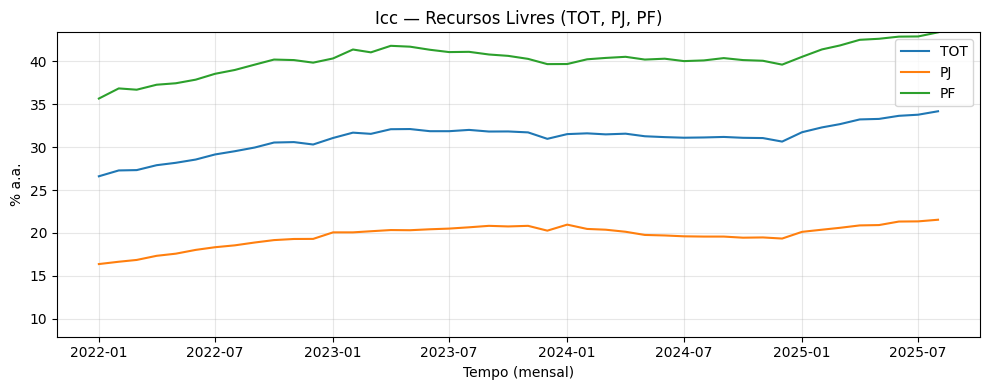

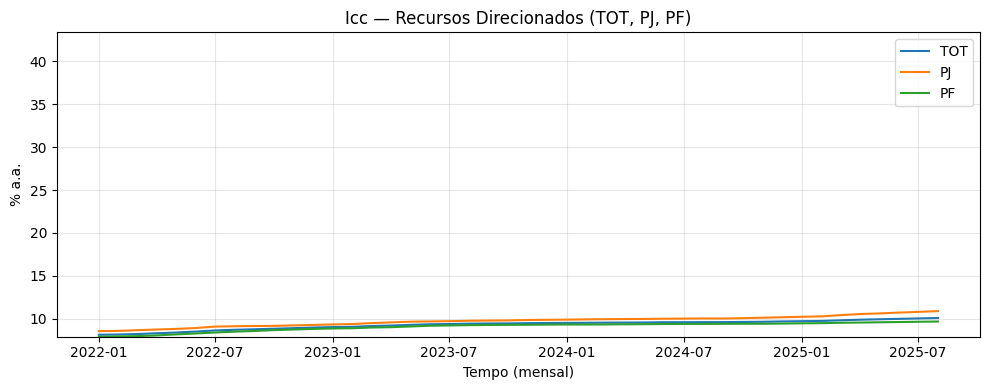

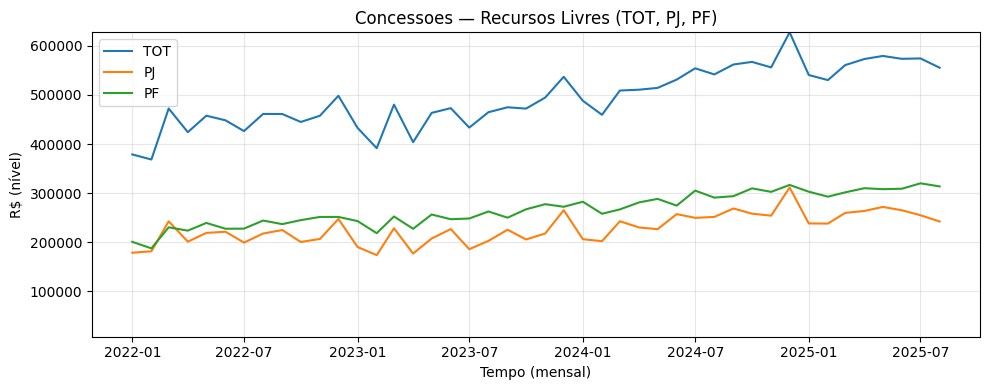

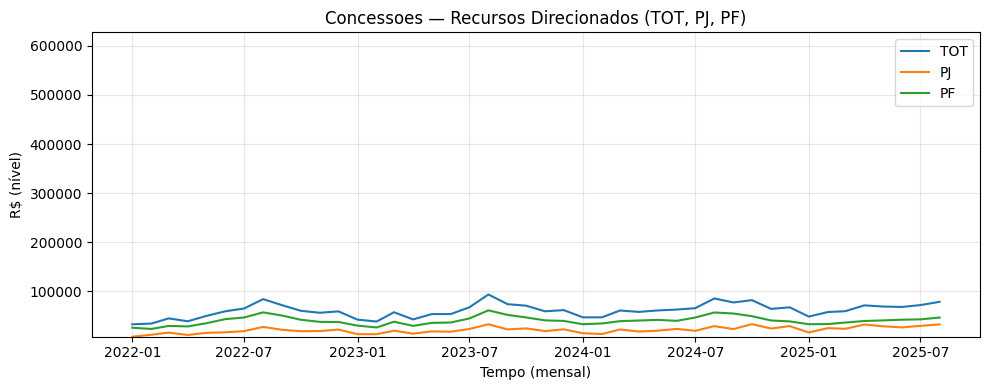

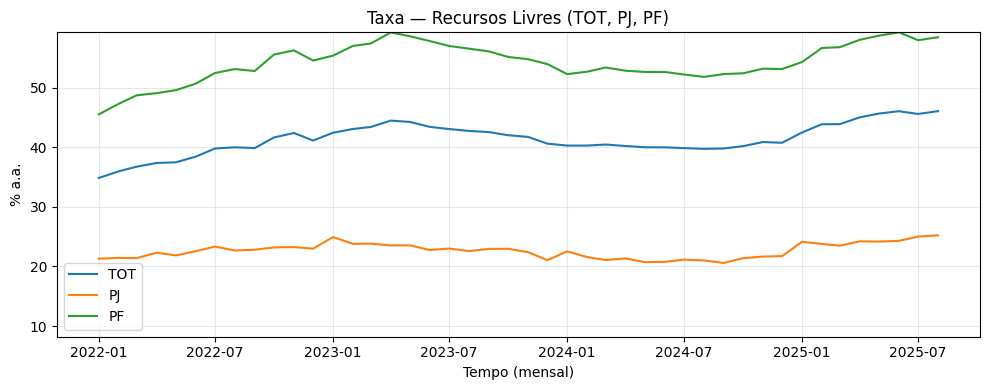

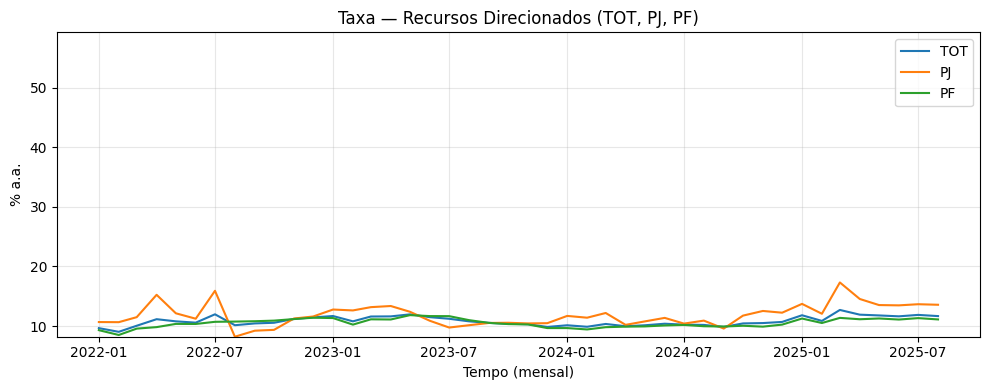

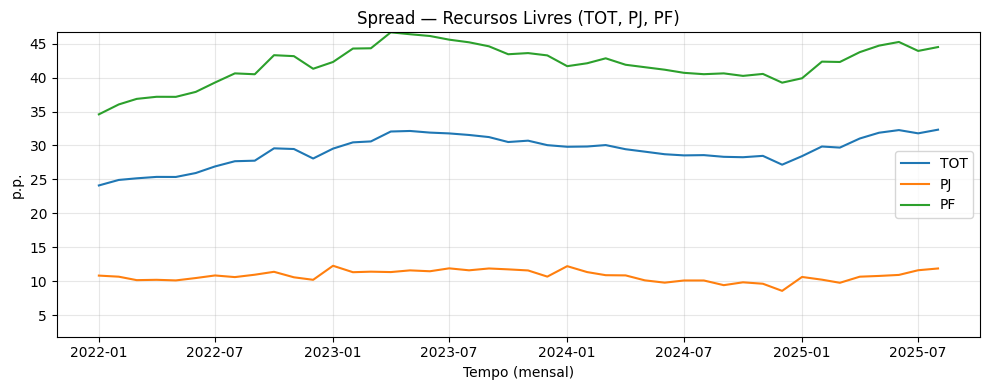

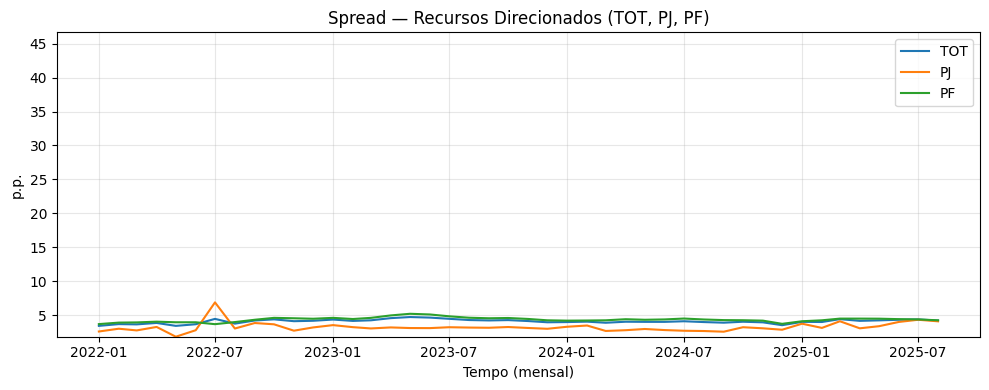

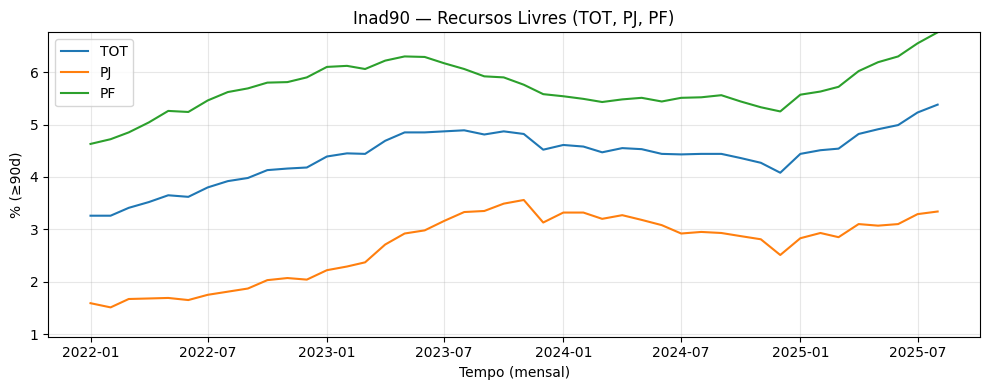

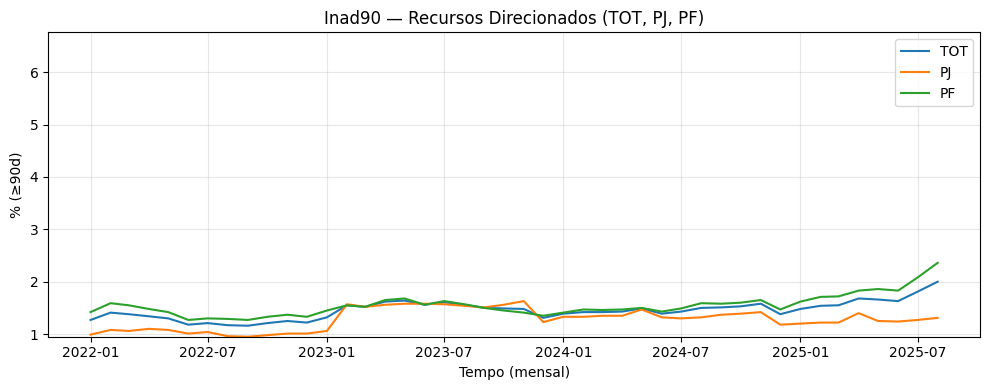

[aviso] coluna 'selic_4189' não encontrada.


In [ ]:
PERIODO_INI = "2022-01"
PERIODO_FIM = "2025-08"
ini = pd.to_datetime(PERIODO_INI + "-01")
fim = pd.to_datetime(PERIODO_FIM + "-01")
painel = painel.loc[(painel.index >= ini) & (painel.index <= fim)]

eixo_tempo = painel.index

if "selic_4189" in painel.columns:
    painel = painel.rename(columns={"selic_4189": "selic"})

# Mapeamento de séries
SERIES = {
    ("icc", "RL"): {"TOT": "icc_RL_TOT_25354", "PJ": "icc_RL_PJ_25355", "PF": "icc_RL_PF_25356"},
    ("icc", "RD"): {"TOT": "icc_RD_TOT_25357", "PJ": "icc_RD_PJ_25358", "PF": "icc_RD_PF_25359"},
    ("concessoes", "RL"): {"TOT": "concessoes_RL_TOT_20634", "PJ": "concessoes_RL_PJ_20635", "PF": "concessoes_RL_PF_20662"},
    ("concessoes", "RD"): {"TOT": "concessoes_RD_TOT_20685", "PJ": "concessoes_RD_PJ_20686", "PF": "concessoes_RD_PF_20698"},
    ("taxa", "RL"): {"TOT": "taxa_RL_TOT_20717", "PJ": "taxa_RL_PJ_20718", "PF": "taxa_RL_PF_20740"},
    ("taxa", "RD"): {"TOT": "taxa_RD_TOT_20756", "PJ": "taxa_RD_PJ_20757", "PF": "taxa_RD_PF_20768"},
    ("spread", "RL"): {"TOT": "spread_RL_TOT_20786", "PJ": "spread_RL_PJ_20787", "PF": "spread_RL_PF_20809"},
    ("spread", "RD"): {"TOT": "spread_RD_TOT_20825", "PJ": "spread_RD_PJ_20826", "PF": "spread_RD_PF_20837"},
    ("inad90", "RL"): {"TOT": "inad90_RL_TOT_21085", "PJ": "inad90_RL_PJ_21086", "PF": "inad90_RL_PF_21112"},
    ("inad90", "RD"): {"TOT": "inad90_RD_TOT_21132", "PJ": "inad90_RD_PJ_21133", "PF": "inad90_RD_PF_21145"},
}

UNIDADES = {
    "icc": "% a.a.", "concessoes": "R$ (nível)", "taxa": "% a.a.", "spread": "p.p.", "inad90": "% (≥90d)", "selic": "% a.a."
}
TITULO = {"RL": "Recursos Livres", "RD": "Recursos Direcionados"}


def coletar_series(indicador: str, grupo: str) -> dict:
    nomes = SERIES.get((indicador, grupo), {})
    dados = {}
    for seg in ["TOT", "PJ", "PF"]:
        col = nomes.get(seg)
        if col and col in painel.columns:
            dados[seg] = pd.to_numeric(painel[col], errors="coerce")
    return dados

def limites_comuns(indicador: str):
    ys = []
    for g in ["RL", "RD"]:
        trio = coletar_series(indicador, g)
        for s in trio.values():
            ys.append(s.dropna())
    if not ys:
        return None
    y_all = pd.concat(ys)
    return (y_all.min(), y_all.max())

def plotar_indicador(indicador: str, grupo: str, ylim=None):
    trio = coletar_series(indicador, grupo)
    if not trio:
        print(f"[aviso] mapeamento ausente ou colunas inexistentes para {indicador.upper()} - {grupo}")
        return
    plt.figure(figsize=(10,4))
    for seg in ["TOT", "PJ", "PF"]:
        if seg in trio:
            plt.plot(eixo_tempo, trio[seg].values, label=seg)
    plt.title(f"{indicador.capitalize()} — {TITULO[grupo]} (TOT, PJ, PF)")
    plt.ylabel(UNIDADES.get(indicador, ""))
    plt.xlabel("Tempo (mensal)")
    if ylim is not None:
        plt.ylim(ylim)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plotar_selic():
    if "selic_4189" not in painel.columns:
        print("[aviso] coluna 'selic_4189' não encontrada.")
        return
    plt.figure(figsize=(10,4))
    y = pd.to_numeric(painel["selic_4189"], errors="coerce")
    plt.plot(painel.index, y.values, label="selic_4189")
    plt.title("Selic (mensal)")
    plt.ylabel("% a.a.")
    plt.xlabel("Tempo (mensal)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


for indicador in ["icc", "concessoes", "taxa", "spread", "inad90"]:
    y_lim = limites_comuns(indicador)  # mesma escala RL×RD do mesmo indicador (opcional)
    for grupo in ["RL", "RD"]:
        plotar_indicador(indicador, grupo, ylim=y_lim)

plotar_selic()


# 📈 Correlação com as Séries-Alvo (Spreads)

### O que é correlação?
- É uma **medida estatística** que mostra **o quanto duas variáveis se relacionam**.  
- Vai de **-1 a +1**:  
  - **+1** = correlação perfeita positiva (sobem juntas).  
  - **-1** = correlação perfeita negativa (quando uma sobe, a outra cai).  
  - **0** = sem relação linear.

### No projeto de spreads
- As **séries-alvo** são os diferentes tipos de **spread bancário** (ex.: `spread_RL_PJ`, `spread_RD_TOT`).  
- A ideia é verificar quais variáveis (juros, concessões, ICC) têm maior relação com cada spread.  

### Exemplo de gráfico de correlação (heatmap)
- Cada célula mostra o **coeficiente de correlação**.  
- Cores quentes (vermelho) = correlação forte positiva.  
- Cores frias (azul) = correlação negativa.  

Esse gráfico ajuda a **visualizar de forma rápida quais variáveis explicam melhor os spreads**.

In [11]:
# listas das séries-alvo (colunas da base)
spreads_alvo = [
    "spread_RD_TOT_20825",
    "spread_RD_PJ_20826",
    "spread_RD_PF_20837",
    "spread_RL_TOT_20786",
    "spread_RL_PJ_20787",
    "spread_RL_PF_20809",
]

# filtra apenas as que existem como COLUNAS
spreads_presentes = [s for s in spreads_alvo if s in painel.columns]
if len(spreads_presentes) == 0:
    raise ValueError("Nenhuma das séries de spread informadas foi encontrada nas colunas do painel.")

def correlacoes_com_alvo(painel: pd.DataFrame, alvo: str, top_n: int = 15) -> pd.DataFrame:
    """
    Calcula correlação de Pearson entre a série-alvo (coluna) e todas as demais séries (colunas),
    usando apenas os meses onde o alvo tem dado. Retorna dataframe ordenado por |correlação|.
    """
    # garante tipos numéricos
    painel_num = painel.apply(pd.to_numeric, errors="coerce")

    # alvo como série (coluna) e meses válidos (sem NaN no alvo)
    serie_alvo = painel_num[alvo]
    meses_validos = serie_alvo.index[serie_alvo.notna()]
    if len(meses_validos) < 3:
        return pd.DataFrame(columns=["corr", "abs"])

    # outras séries: remove o alvo, restringe aos mesmos meses e calcula correlação coluna-a-coluna
    outras_series = painel_num.drop(columns=[alvo]).loc[meses_validos]

    # correlação de cada coluna de 'outras_series' com 'serie_alvo' (mesmos meses)
    corr = outras_series.corrwith(serie_alvo.loc[meses_validos])

    corr = corr.dropna()
    resultado = (
        pd.DataFrame({"corr": corr, "abs": corr.abs()})
          .sort_values("abs", ascending=False)
          .head(top_n)
    )
    return resultado

# calcula e mostra as tabelas de correlação para cada spread-alvo
tabelas_correlacao = {}
for alvo in spreads_presentes:
    print(f"\n=== Correlações com alvo: {alvo} ===")
    tabela = correlacoes_com_alvo(painel, alvo, top_n=15)
    tabelas_correlacao[alvo] = tabela
    display(tabela)



=== Correlações com alvo: spread_RD_TOT_20825 ===


,corr,abs
spread_RL_PF_20809,0.815274,0.815274
spread_RD_PF_20837,0.812541,0.812541
inad90_RL_PF_21112,0.794183,0.794183
taxa_RL_PF_20740,0.793250,0.793250
spread_RL_TOT_20786,0.778193,0.778193
taxa_RL_TOT_20717,0.739689,0.739689
taxa_RD_PF_20768,0.719308,0.719308
icc_RL_PF_25356,0.711580,0.711580
inad90_RL_TOT_21085,0.671135,0.671135
icc_RL_TOT_25354,0.648329,0.648329



=== Correlações com alvo: spread_RD_PJ_20826 ===


,corr,abs
spread_RD_TOT_20825,0.504042,0.504042
taxa_RD_PJ_20757,0.498762,0.498762
taxa_RL_PJ_20718,0.495252,0.495252
taxa_RD_TOT_20756,0.494203,0.494203
selic,0.418987,0.418987
taxa_RD_PF_20768,0.313475,0.313475
taxa_RL_TOT_20717,0.312676,0.312676
inad90_RL_PF_21112,0.294386,0.294386
taxa_RL_PF_20740,0.272681,0.272681
spread_RL_PJ_20787,0.256782,0.256782



=== Correlações com alvo: spread_RD_PF_20837 ===


,corr,abs
spread_RL_PF_20809,0.837442,0.837442
spread_RD_TOT_20825,0.812541,0.812541
spread_RL_TOT_20786,0.775779,0.775779
taxa_RL_PF_20740,0.732660,0.732660
inad90_RL_PF_21112,0.722584,0.722584
inad90_RL_TOT_21085,0.659718,0.659718
icc_RL_PF_25356,0.654384,0.654384
taxa_RL_TOT_20717,0.643221,0.643221
taxa_RD_PF_20768,0.627082,0.627082
inad90_RD_PJ_21133,0.613317,0.613317



=== Correlações com alvo: spread_RL_TOT_20786 ===


,corr,abs
spread_RL_PF_20809,0.977440,0.977440
inad90_RL_TOT_21085,0.946354,0.946354
icc_RL_PJ_25355,0.931667,0.931667
icc_RL_PF_25356,0.924982,0.924982
taxa_RL_PF_20740,0.922282,0.922282
icc_RL_TOT_25354,0.919265,0.919265
taxa_RL_TOT_20717,0.905622,0.905622
inad90_RL_PF_21112,0.896561,0.896561
spread_RD_TOT_20825,0.778193,0.778193
spread_RD_PF_20837,0.775779,0.775779



=== Correlações com alvo: spread_RL_PJ_20787 ===


,corr,abs
concessoes_RL_PJ_20635,-0.606079,0.606079
inad90_RL_PF_21112,0.560222,0.560222
spread_RL_TOT_20786,0.547991,0.547991
spread_RD_TOT_20825,0.547409,0.547409
spread_RL_PF_20809,0.543093,0.543093
taxa_RL_PJ_20718,0.529594,0.529594
spread_RD_PF_20837,0.473515,0.473515
selic,0.461536,0.461536
concessoes_RL_TOT_20634,-0.448247,0.448247
inad90_RL_TOT_21085,0.440589,0.440589



=== Correlações com alvo: spread_RL_PF_20809 ===


,corr,abs
spread_RL_TOT_20786,0.977440,0.977440
taxa_RL_PF_20740,0.932992,0.932992
inad90_RL_PF_21112,0.893695,0.893695
taxa_RL_TOT_20717,0.876983,0.876983
icc_RL_PF_25356,0.874746,0.874746
inad90_RL_TOT_21085,0.874740,0.874740
icc_RL_PJ_25355,0.864532,0.864532
icc_RL_TOT_25354,0.843589,0.843589
spread_RD_PF_20837,0.837442,0.837442
spread_RD_TOT_20825,0.815274,0.815274


# 3) Modelos Tradicionais

In [ ]:
%pip install -q statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 0) Preparação da base
dados = painel.copy() 
# 0.1) garante índice temporal e ordenação cronológica
if not np.issubdtype(dados.index.dtype, np.datetime64):
    dados.index = pd.to_datetime(dados.index, errors="coerce")
dados = dados.sort_index()
dados = dados.apply(pd.to_numeric, errors="coerce") #força tipo numérico nas colunas

# janela de análise
ini, fim = pd.Timestamp("2022-01-01"), pd.Timestamp("2025-08-01")
dados = dados.loc[(dados.index >= ini) & (dados.index <= fim)]

In [16]:
# Alvos (spreads) existentes na base
spreads_alvo = [
    "spread_RD_TOT_20825", "spread_RD_PJ_20826", "spread_RD_PF_20837",
    "spread_RL_TOT_20786", "spread_RL_PJ_20787", "spread_RL_PF_20809",
]
spreads_alvo = [s for s in spreads_alvo if s in dados.columns]

# Escolha de exógenas por alvo (máx. 1 por bloco)
EXOG_POR_ALVO = {
    "spread_RD_TOT_20825": ["taxa_RD_TOT_20756", "inad90_RD_TOT_21132", "selic_4189"],
    "spread_RD_PJ_20826":  ["taxa_RD_PJ_20757",  "inad90_RD_PJ_21133",  "selic_4189"],  # ou concessoes_RD_PJ_20686
    "spread_RD_PF_20837":  ["taxa_RD_PF_20768",  "inad90_RD_PF_21145",  "selic_4189"],
    "spread_RL_TOT_20786": ["taxa_RL_TOT_20717", "inad90_RL_TOT_21085"],                 # sem ICC junto com taxa
    "spread_RL_PJ_20787":  ["taxa_RL_PJ_20718",  "inad90_RL_PJ_21086",  "concessoes_RL_PJ_20635"],
    "spread_RL_PF_20809":  ["taxa_RL_PF_20740",  "inad90_RL_PF_21112",  "selic_4189"],
}

# Defasagens por exógena (lags)
LAGS_EXOG = {
    "selic_4189": [3],  # política monetária costuma afetar com defasagem
    "taxa_RD_TOT_20756": [1], "taxa_RD_PJ_20757": [1], "taxa_RD_PF_20768": [1],
    "taxa_RL_TOT_20717": [1], "taxa_RL_PJ_20718": [1], "taxa_RL_PF_20740": [1],
    "inad90_RD_TOT_21132": [1, 2], "inad90_RD_PJ_21133": [1, 2], "inad90_RD_PF_21145": [1, 2],
    "inad90_RL_TOT_21085": [1, 2], "inad90_RL_PJ_21086": [1, 2], "inad90_RL_PF_21112": [1, 2],
    "concessoes_RL_PJ_20635": [1],
}

# utilitário para criar lags
def criar_lags_mapa(df: pd.DataFrame, mapa_lags: dict[str, list[int]]) -> pd.DataFrame:
    saida = pd.DataFrame(index=df.index)
    for col, lags in mapa_lags.items():
        if col in df.columns:
            serie = pd.to_numeric(df[col], errors="coerce")
            for k in lags:
                saida[f"{col}_lag{k}"] = serie.shift(k)
    return saida

In [17]:
def estacionarizar(df: pd.DataFrame, d: int = 1, D: int = 1, s: int = 12) -> pd.DataFrame:
    """
    Aplica diferenças na(s) coluna(s):
      - d = diferença regular (ex.: 1)
      - D = diferença sazonal (ex.: 1) com período s (12 para mensal)
    """
    X = df.copy()
    if d > 0:
        X = X.diff(d)
    if D > 0:
        X = X.diff(s)
    return X

def padronizar_treino_teste(X_tr: pd.DataFrame, X_te: pd.DataFrame):
    """
    Z-score com parâmetros estimados apenas no treino.
    """
    esc = StandardScaler()
    Xtr = pd.DataFrame(esc.fit_transform(X_tr), index=X_tr.index, columns=X_tr.columns)
    Xte = pd.DataFrame(esc.transform(X_te),    index=X_te.index, columns=X_te.columns)
    return Xtr, Xte

def remover_colinear(X: pd.DataFrame, limiar: float = 0.90):
    """
    Remove colunas muito correlacionadas entre si (|r|>limiar).
    Mantém a primeira ocorrência e remove duplicatas colineares.
    """
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop = [c for c in upper.columns if (upper[c] > limiar).any()]
    return X.drop(columns=drop), drop

In [18]:
def dividir_treino_teste(y: pd.Series, X: pd.DataFrame | None, fim_treino: str):
    corte = pd.Timestamp(fim_treino + "-01")
    mask_tr = y.index <= corte
    y_tr, y_te = y[mask_tr], y[~mask_tr]
    X_tr = X.loc[mask_tr] if X is not None else None
    X_te = X.loc[~mask_tr] if X is not None else None
    return y_tr, X_tr, y_te, X_te

def ajustar_modelo(y_tr, X_tr, ordem, saz):
    """
    SARIMAX com restrições para evitar soluções explosivas.
    """
    mod = SARIMAX(
        y_tr, exog=X_tr,
        order=ordem, seasonal_order=saz,
        trend="c",
        enforce_stationarity=True,
        enforce_invertibility=True,
    )
    return mod.fit(disp=False)

def buscar_melhor_por_bic(y_tr, X_tr, grid_ordens, grid_sazonal):
    """
    Varre um grid pequeno e seleciona a menor BIC (penaliza complexidade).
    """
    melhor = None
    for ord_ in grid_ordens:
        for saz_ in grid_sazonal:
            try:
                res = ajustar_modelo(y_tr, X_tr, ord_, saz_)
                bic = res.bic
                if (melhor is None) or (bic < melhor[0]):
                    melhor = (bic, ord_, saz_, res)
            except Exception:
                pass
    if melhor is None:
        raise RuntimeError("Nenhum modelo convergiu.")
    return melhor  # (bic, ordem, sazonal, results)

def prever_passos(modelo, passos: int, X_te=None):
    return modelo.get_forecast(steps=passos, exog=X_te).predicted_mean

def calcular_metricas(y_verd, y_prev):
    y_verd, y_prev = y_verd.align(y_prev, join="inner")
    mae  = float(np.mean(np.abs(y_verd - y_prev)))
    rmse = float(np.sqrt(np.mean((y_verd - y_prev)**2)))
    mape = float(np.mean(np.abs((y_verd - y_prev) / y_verd.replace(0, np.nan))) * 100.0)
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape}

def plotar_previsao(y_tr, y_te, y_prev, titulo: str):
    plt.figure(figsize=(10,4))
    plt.plot(y_tr.index, y_tr.values, label="treino")
    if len(y_te) > 0:
        plt.plot(y_te.index, y_te.values, "--", label="teste")
        plt.plot(y_prev.index, y_prev.values, label="previsão", linewidth=2)
    plt.title(titulo)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [21]:
def comparar_modelos_estaveis(
    alvo: str,
    fim_treino: str = "2024-12",
    grid_ar = ((0,1,1),(1,1,0),(1,1,1),(2,1,1)),
    grid_saz = ((0,1,1,12),(1,1,0,12),(1,1,1,12))
):
    if alvo not in dados.columns:
        raise ValueError(f"Alvo '{alvo}' não existe nas colunas.")

    # ---------- Série alvo ----------
    y = pd.to_numeric(dados[alvo], errors="coerce").dropna()

    # ===== ARIMA (baseline) =====
    y_tr, _, y_te, _ = dividir_treino_teste(y, None, fim_treino)
    _, ord_ar, saz_ar, res_ar = buscar_melhor_por_bic(y_tr, None, grid_ar, grid_saz)
    prev_ar = prever_passos(res_ar, passos=len(y_te), X_te=None)
    met_ar  = calcular_metricas(y_te, prev_ar)

    # ===== ARIMAX (X enxutas com lags, diffs e padronização) =====
    # 1) escolher no máx. 1 por bloco
    exogs = EXOG_POR_ALVO.get(alvo, ["selic_4189"])
    exogs = [x for x in exogs if (x in dados.columns) and (not str(x).startswith("spread_"))]
    mapa_lags = {e: LAGS_EXOG.get(e, [1]) for e in exogs}

    # 2) criar lags
    X_lag = criar_lags_mapa(dados, mapa_lags)

    # 3) split temporal
    _, X_tr0, _, X_te0 = dividir_treino_teste(y, X_lag, fim_treino)

    # 4) estacionarizar X (mesma lógica do Y): diff 1 + sazonal 12
    X_tr1 = estacionarizar(X_tr0, d=1, D=1, s=12)
    X_te1 = estacionarizar(X_te0, d=1, D=1, s=12)

    # 5) remover colunas todas-NaN e colunas constantes (std≈0) no TREINO
    X_tr1 = X_tr1.dropna(axis=1, how="all")
    X_te1 = X_te1.dropna(axis=1, how="all")

    if X_tr1.shape[1] > 0:
        const_cols = X_tr1.columns[X_tr1.std(skipna=True) < 1e-12]
        if len(const_cols) > 0:
            X_tr1 = X_tr1.drop(columns=const_cols)
            X_te1 = X_te1.drop(columns=const_cols, errors="ignore")

    # 6) alinhar y aos X e dropar linhas com NaN (treino e teste)
    y_tr1 = y_tr.loc[X_tr1.index]
    y_te1 = y_te.loc[X_te1.index]

    mask_tr = X_tr1.notna().all(axis=1)
    mask_te = X_te1.notna().all(axis=1)

    X_tr1 = X_tr1.loc[mask_tr]
    y_tr1 = y_tr1.loc[mask_tr]

    X_te1 = X_te1.loc[mask_te]
    y_te1 = y_te1.loc[mask_te]

    # 7) se não sobrou exógena válida, faz fallback p/ ARIMA
    if X_tr1.shape[1] == 0 or X_te1.shape[1] == 0:
        resumo = pd.DataFrame([
            {"modelo": "ARIMA", "ordem": ord_ar, "sazonal": saz_ar, **met_ar},
            {"modelo": "ARIMAX", "ordem": None, "sazonal": None, "MAE": np.nan, "RMSE": np.nan, "MAPE_%": np.nan}
        ]).set_index("modelo")
        plotar_previsao(y_tr, y_te, prev_ar, f"ARIMA — {alvo} (ord={ord_ar}, saz={saz_ar})")
        print("[aviso] Nenhuma exógena válida sobrou após limpeza; ARIMAX não estimado.")
        return resumo, {"removidas_por_colinearidade": [], "fallback_arima": True}

    # 8) padronizar (fit no treino) e tratar inf/NaN após padronização
    X_tr2, X_te2 = padronizar_treino_teste(X_tr1, X_te1)
    X_tr2 = X_tr2.replace([np.inf, -np.inf], np.nan).dropna()
    X_te2 = X_te2.replace([np.inf, -np.inf], np.nan).dropna()

    # re-alinhar y novamente se linhas foram perdidas
    y_tr2 = y_tr1.loc[X_tr2.index]
    y_te2 = y_te1.loc[X_te2.index]

    # 9) remover colinearidade forte (|r|>0,90) DEPOIS de padronizar
    if X_tr2.shape[1] > 1:
        X_tr3, drop_cols = remover_colinear(X_tr2, limiar=0.90)
    else:
        X_tr3, drop_cols = X_tr2, []

    X_te3 = X_te2[X_tr3.columns]  # mesmas colunas
    # garantir alinhamento perfeito com y_te
    X_te3 = X_te3.loc[y_te2.index]

    # 10) escolher ordens por BIC e ajustar
    _, ord_ax, saz_ax, res_ax = buscar_melhor_por_bic(y_tr2, X_tr3, grid_ar, grid_saz)
    prev_ax = prever_passos(res_ax, passos=len(y_te2), X_te=X_te3)
    met_ax  = calcular_metricas(y_te2, prev_ax)

    # ---- Resumo e gráficos ----
    resumo = pd.DataFrame([
        {"modelo": "ARIMA",  "ordem": ord_ar,  "sazonal": saz_ar,  **met_ar},
        {"modelo": "ARIMAX", "ordem": ord_ax, "sazonal": saz_ax, **met_ax},
    ]).set_index("modelo")

    plotar_previsao(y_tr,  y_te,  prev_ar, f"ARIMA  — {alvo} (ord={ord_ar}, saz={saz_ar})")
    plotar_previsao(y_tr2, y_te2, prev_ax, f"ARIMAX — {alvo} (ord={ord_ax}, saz={saz_ax})")

    return resumo, {"removidas_por_colinearidade": drop_cols, "fallback_arima": False}



### Avaliando spread_RD_TOT_20825


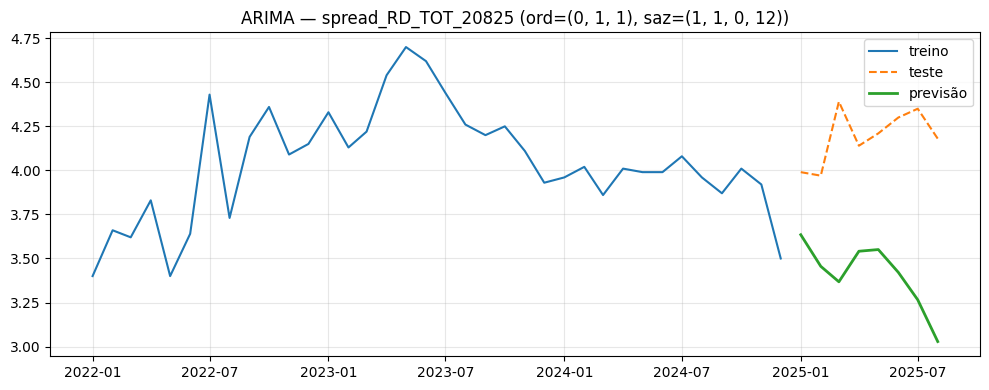

[aviso] Nenhuma exógena válida sobrou após limpeza; ARIMAX não estimado.


,ordem,sazonal,MAE,RMSE,MAPE_%
modelo,,,,,
ARIMA,"(0, 1, 1)","(1, 1, 0, 12)",0.783189,0.829488,18.525516
ARIMAX,None,None,NaN,NaN,NaN



### Avaliando spread_RD_PJ_20826


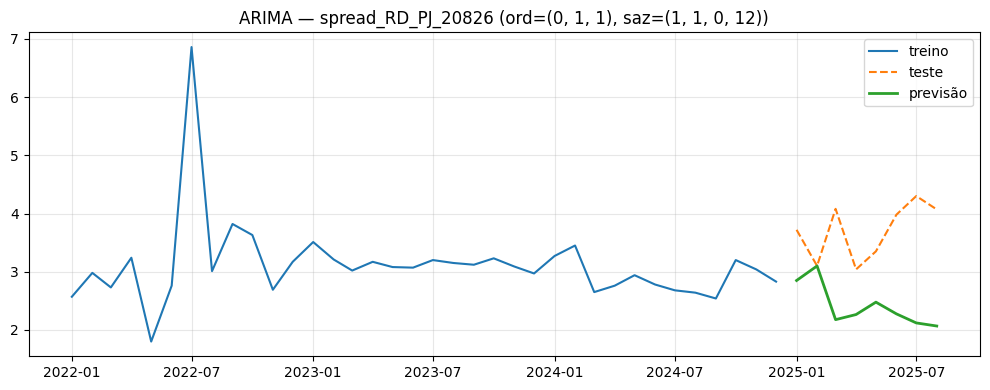

[aviso] Nenhuma exógena válida sobrou após limpeza; ARIMAX não estimado.


,ordem,sazonal,MAE,RMSE,MAPE_%
modelo,,,,,
ARIMA,"(0, 1, 1)","(1, 1, 0, 12)",1.288968,1.475454,33.052023
ARIMAX,None,None,NaN,NaN,NaN



### Avaliando spread_RD_PF_20837


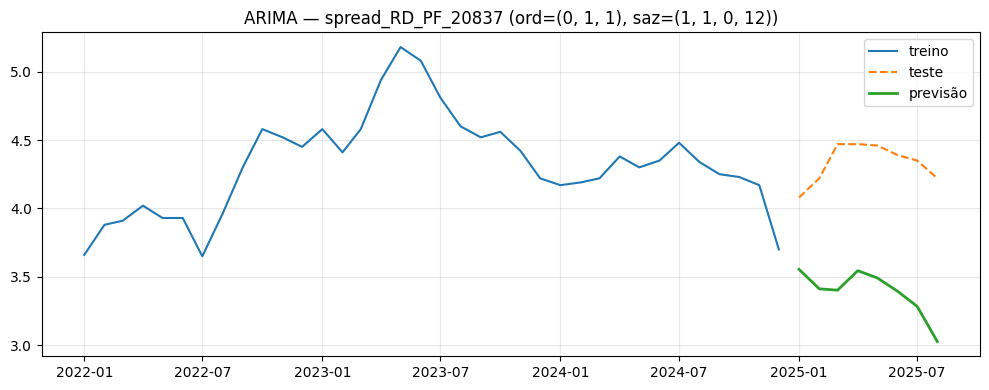

[aviso] Nenhuma exógena válida sobrou após limpeza; ARIMAX não estimado.


,ordem,sazonal,MAE,RMSE,MAPE_%
modelo,,,,,
ARIMA,"(0, 1, 1)","(1, 1, 0, 12)",0.943969,0.962941,21.729175
ARIMAX,None,None,NaN,NaN,NaN



### Avaliando spread_RL_TOT_20786


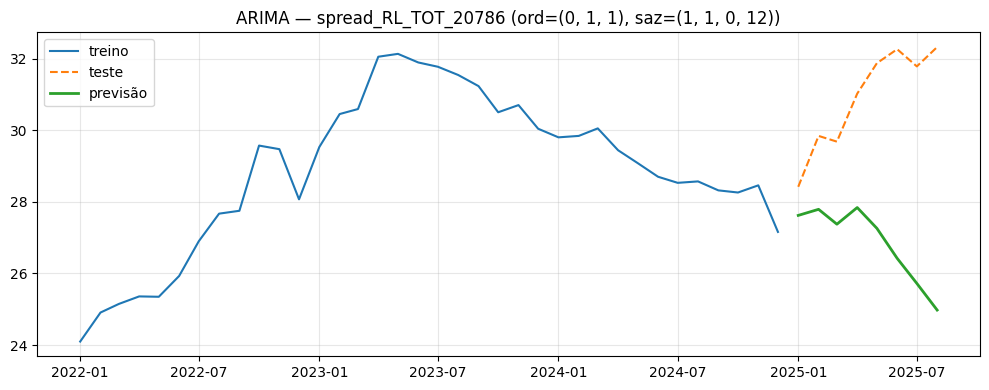

[aviso] Nenhuma exógena válida sobrou após limpeza; ARIMAX não estimado.


,ordem,sazonal,MAE,RMSE,MAPE_%
modelo,,,,,
ARIMA,"(0, 1, 1)","(1, 1, 0, 12)",4.022141,4.557434,12.752992
ARIMAX,None,None,NaN,NaN,NaN



### Avaliando spread_RL_PJ_20787


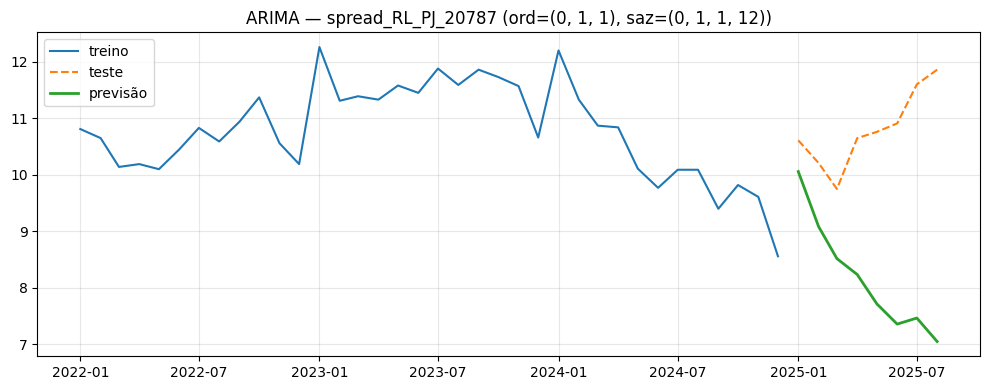

[aviso] Nenhuma exógena válida sobrou após limpeza; ARIMAX não estimado.


,ordem,sazonal,MAE,RMSE,MAPE_%
modelo,,,,,
ARIMA,"(0, 1, 1)","(0, 1, 1, 12)",2.606818,2.978315,23.56117
ARIMAX,None,None,NaN,NaN,NaN



### Avaliando spread_RL_PF_20809


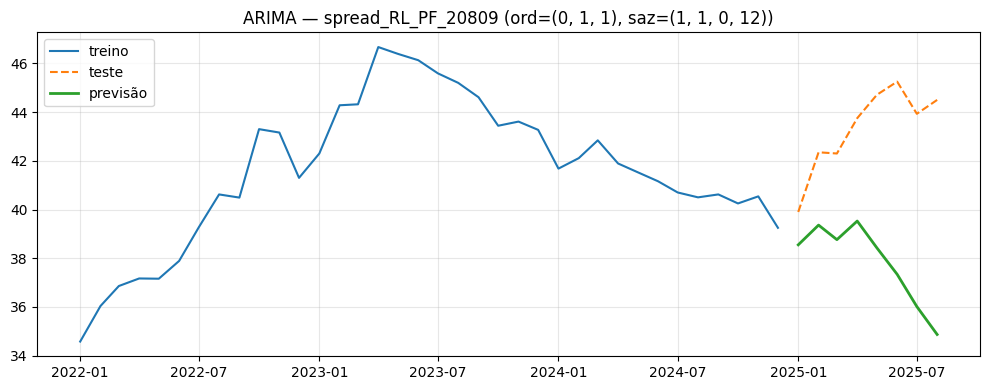

[aviso] Nenhuma exógena válida sobrou após limpeza; ARIMAX não estimado.


,ordem,sazonal,MAE,RMSE,MAPE_%
modelo,,,,,
ARIMA,"(0, 1, 1)","(1, 1, 0, 12)",5.479591,6.108747,12.45573
ARIMAX,None,None,NaN,NaN,NaN


,alvo,modelo,ordem,sazonal,MAE,RMSE,MAPE_%
4,spread_RD_PF_20837,ARIMA,"(0, 1, 1)","(1, 1, 0, 12)",0.943969,0.962941,21.729175
5,spread_RD_PF_20837,ARIMAX,None,None,NaN,NaN,NaN
2,spread_RD_PJ_20826,ARIMA,"(0, 1, 1)","(1, 1, 0, 12)",1.288968,1.475454,33.052023
3,spread_RD_PJ_20826,ARIMAX,None,None,NaN,NaN,NaN
0,spread_RD_TOT_20825,ARIMA,"(0, 1, 1)","(1, 1, 0, 12)",0.783189,0.829488,18.525516
1,spread_RD_TOT_20825,ARIMAX,None,None,NaN,NaN,NaN
10,spread_RL_PF_20809,ARIMA,"(0, 1, 1)","(1, 1, 0, 12)",5.479591,6.108747,12.455730
11,spread_RL_PF_20809,ARIMAX,None,None,NaN,NaN,NaN
8,spread_RL_PJ_20787,ARIMA,"(0, 1, 1)","(0, 1, 1, 12)",2.606818,2.978315,23.561170
9,spread_RL_PJ_20787,ARIMAX,None,None,NaN,NaN,NaN


In [22]:
resultados = {}
for alvo in spreads_alvo:
    print(f"\n### Avaliando {alvo}")
    resumo, info = comparar_modelos_estaveis(alvo, fim_treino="2024-12")
    display(resumo)
    if info["removidas_por_colinearidade"]:
        print("Removidas por colinearidade:", info["removidas_por_colinearidade"])
    resultados[alvo] = resumo

# Tabela única para comparar quem venceu por alvo (menor RMSE)
tabela_consolidada = (
    pd.concat({k: v for k, v in resultados.items()}, names=["alvo", "modelo"])
      .reset_index()
      .sort_values(["alvo", "RMSE"])
)
display(tabela_consolidada)